# Animal Clasifikasi

## Import Library

In [33]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,  Conv2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Load Dataset

In [2]:
original_dataset_dir = '/kaggle/input/animals10/raw-img'
selected_classes = ['mucca', 'pecora', 'scoiattolo']

In [3]:
base_dir = '/kaggle/working/animals-3-classes'
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(base_dir)

In [4]:
for class_name in selected_classes:
    original_class_path = os.path.join(original_dataset_dir, class_name)
    destination_class_path = os.path.join(base_dir, class_name)
    shutil.copytree(original_class_path, destination_class_path)

## Split Dataset menjadi 70 15 15

In [5]:
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir)

for class_name in selected_classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    
    source_dir = os.path.join(original_dataset_dir, class_name)
    all_files = os.listdir(source_dir)
    
    train_files, temp_files = train_test_split(all_files, test_size=0.3, random_state=42)
    validation_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, class_name, file))
        
    for file in validation_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(validation_dir, class_name, file))

    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, class_name, file))

In [6]:
train_count = sum([len(files) for r, d, files in os.walk(train_dir)])
val_count = sum([len(files) for r, d, files in os.walk(validation_dir)])
test_count = sum([len(files) for r, d, files in os.walk(test_dir)])
total_count = train_count + val_count + test_count

print(f"Data Latih\t: {train_count} gambar ({train_count/total_count:.2%})")
print(f"Data Validasi\t: {val_count} gambar ({val_count/total_count:.2%})")
print(f"Data Uji\t: {test_count} gambar ({test_count/total_count:.2%})")
print(f"Total Gambar\t: {total_count} gambar")

Data Latih	: 3883 gambar (69.99%)
Data Validasi	: 832 gambar (15.00%)
Data Uji	: 833 gambar (15.01%)
Total Gambar	: 5548 gambar


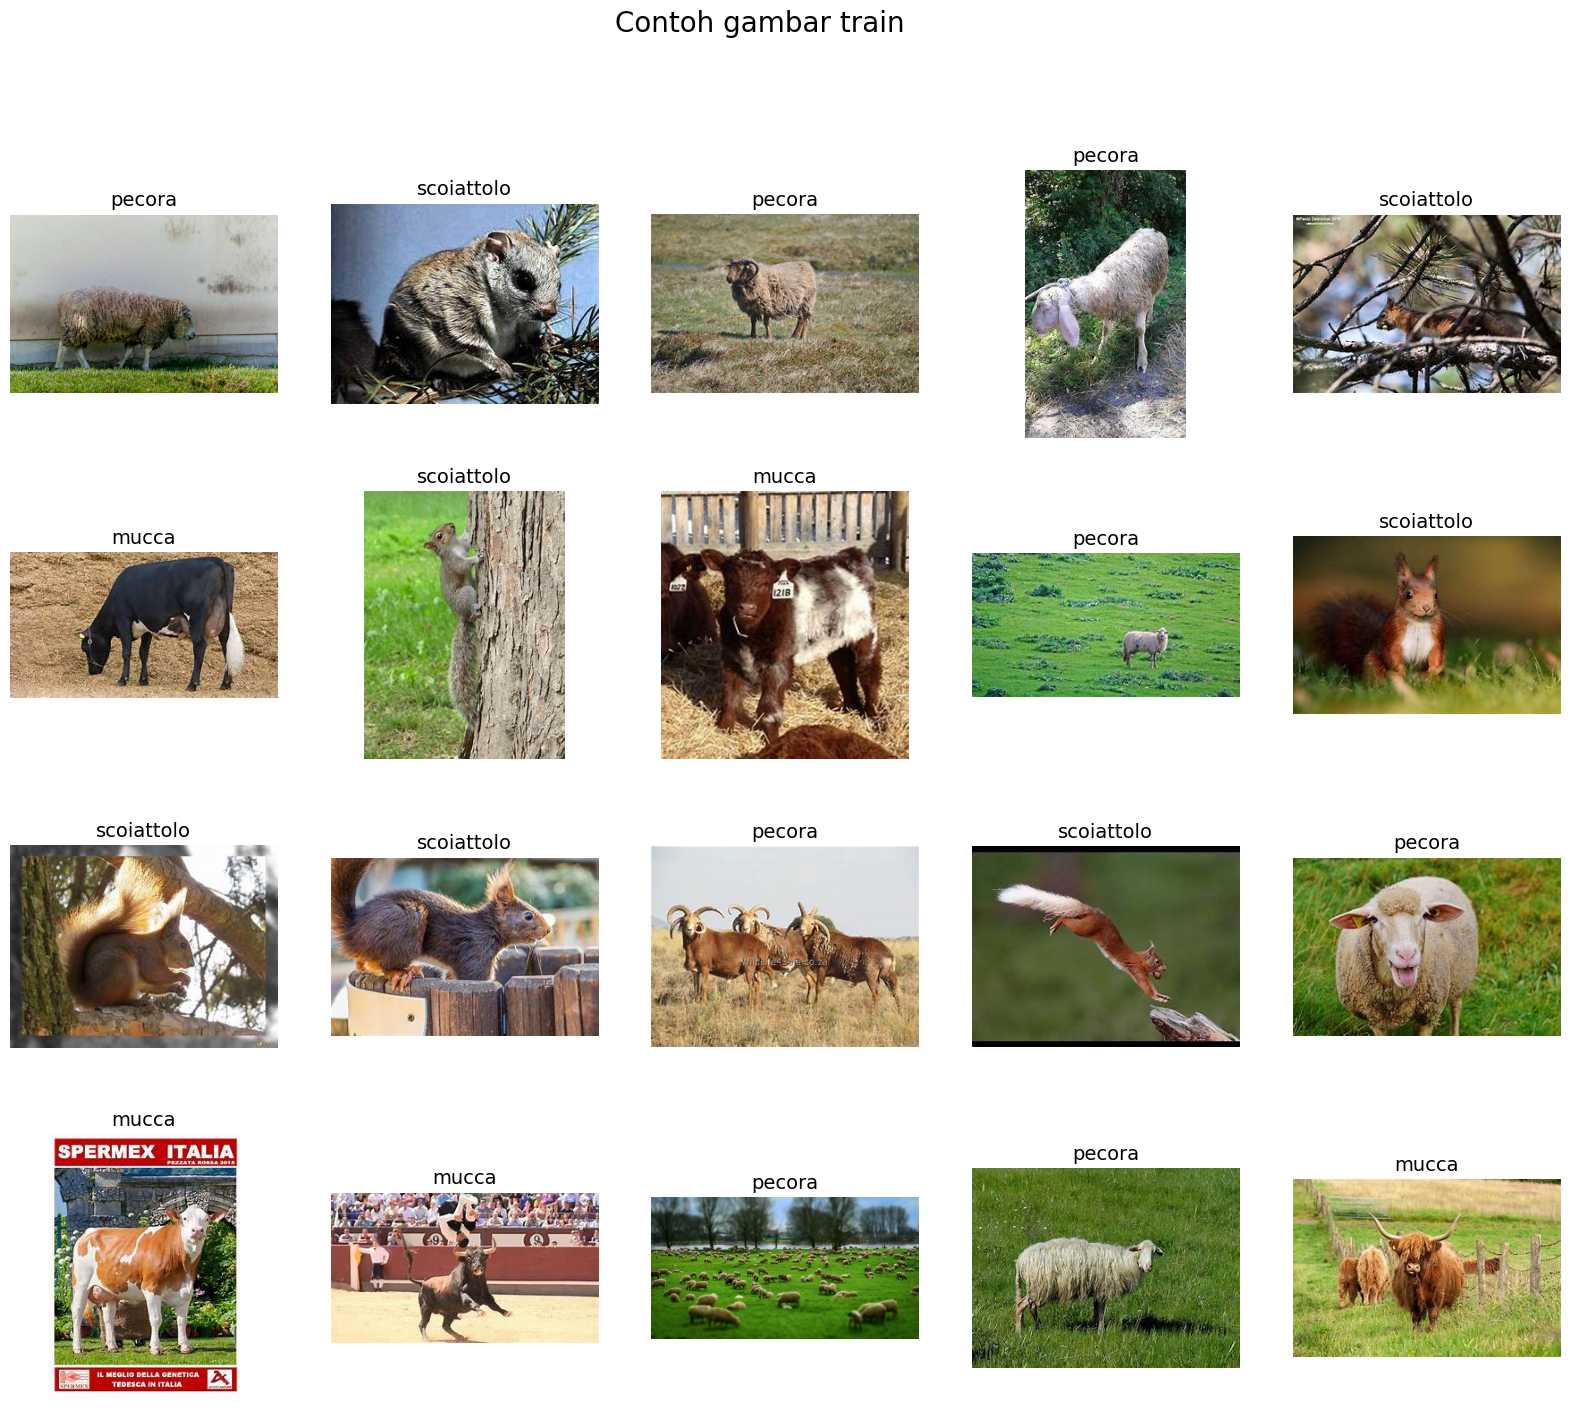

In [7]:
all_train_files = []
for class_name in selected_classes:
    class_dir = os.path.join(train_dir, class_name)
    for fname in os.listdir(class_dir):
        all_train_files.append(os.path.join(class_dir, fname))

random.shuffle(all_train_files)
selected_files = all_train_files[:20]

plt.figure(figsize=(20, 16))
plt.suptitle("Contoh gambar train", fontsize=20)

for i, file_path in enumerate(selected_files):
    sp = plt.subplot(4, 5, i + 1)
    sp.axis('Off')
    
    class_name_title = os.path.basename(os.path.dirname(file_path))
    sp.set_title(class_name_title, fontsize=14)
    
    img = mpimg.imread(file_path)
    plt.imshow(img)

plt.show()

## Preprosessing Data 

In [8]:
IMG_SIZE = 150

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    class_mode='categorical'
)

validation_generator = validation_test_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    class_mode='categorical'
)

test_generator = validation_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 3883 images belonging to 3 classes.
Found 832 images belonging to 3 classes.
Found 833 images belonging to 3 classes.


## Train Model

In [9]:
input_layer = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [10]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

I0000 00:00:1749439834.733150     645 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [43]:
x = base_model(input_layer, training=False)
head_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=x.shape[1:]), 
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(selected_classes), activation='softmax')
])
output_layer = head_model(x)

In [12]:
model = Model(inputs=input_layer, outputs=output_layer)

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True)

In [15]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1749439849.467438     715 service.cc:148] XLA service 0x7c0358004010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749439849.467496     715 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749439851.310565     715 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/61 ━━━━━━━━━━━━━━━━━━━━ 19:21 19s/step - accuracy: 0.3906 - loss: 2.6348

I0000 00:00:1749439857.305984     715 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/61 ━━━━━━━━━━━━━━━━━━━━ 54s 574ms/step - accuracy: 0.6485 - loss: 1.9124 - val_accuracy: 0.9026 - val_loss: 0.2720
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 350ms/step - accuracy: 0.8007 - loss: 0.4759 - val_accuracy: 0.9111 - val_loss: 0.2552
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.8522 - loss: 0.3955 - val_accuracy: 0.9183 - val_loss: 0.2824
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.8614 - loss: 0.4040 - val_accuracy: 0.9291 - val_loss: 0.2391
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 0.8631 - loss: 0.3803 - val_accuracy: 0.9255 - val_loss: 0.2542
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 350ms/step - accuracy: 0.8842 - loss: 0.3371 - val_accuracy: 0.9207 - val_loss: 0.2301
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 355ms/step - accuracy: 0.8860 - loss: 0.3224 - val_accuracy: 0.9363 - val_loss: 0.1998
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 361ms/step - accuracy: 0.8838 - loss: 0.3321 - val_accuracy: 0.923

## Evaluasi Model

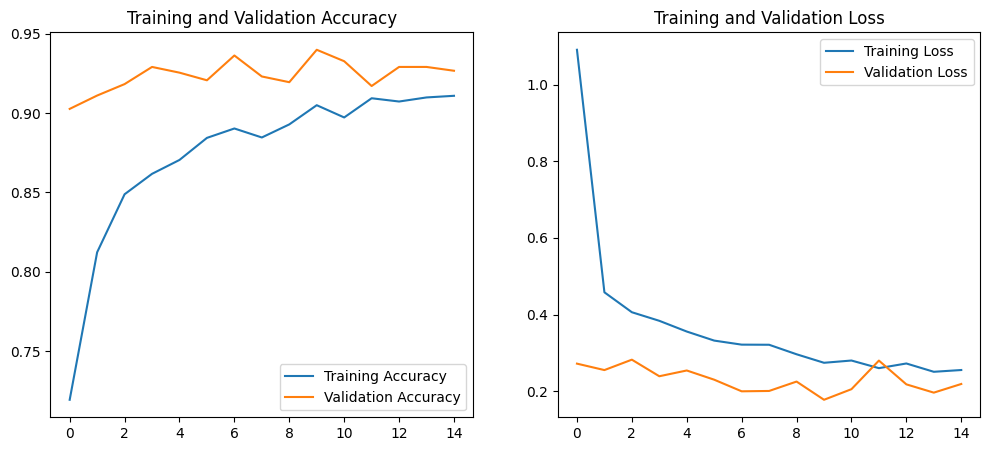

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Akurasi pada data uji: {test_accuracy*100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9430 - loss: 0.1590
Akurasi pada data uji: 93.76%


## Save Model

In [22]:
model.export('saved_model')
print("Model disimpan dalam format TensorFlow SavedModel.")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136357318948624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136357298383248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136357298384400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136357298384016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136357298383440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136357298383632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136357298385552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136357298384592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136357298383056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136357298386320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136357298387856: Te

In [23]:
if not os.path.exists("tflite"):
    os.makedirs("tflite")
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

W0000 00:00:1749440430.847046     645 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749440430.847085     645 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1749440431.033150     645 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [24]:
labels = ['mucca', 'pecora', 'scoiattolo']
os.makedirs("tflite", exist_ok=True)
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

In [27]:
import tensorflowjs as tfjs
if not os.path.exists("tfjs_model"):
    os.makedirs("tfjs_model")
tfjs.converters.save_keras_model(model, "tfjs_model")
print("Model berhasil disimpan dalam format TensorFlow.js di tfjs_model.")

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil disimpan dalam format TensorFlow.js di tfjs_model.


In [28]:
os.makedirs("submission/tfjs_model", exist_ok=True)
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/saved_model", exist_ok=True)

shutil.copy("model.tflite", "submission/tflite/model.tflite")
shutil.copytree("saved_model/variables", "submission/saved_model/variables", dirs_exist_ok=True)
shutil.copy("saved_model/saved_model.pb", "submission/saved_model/saved_model.pb")
shutil.copytree("tfjs_model", "submission/tfjs_model", dirs_exist_ok=True)

shutil.make_archive("/kaggle/working/submission", 'zip', "submission")
print("Model telah disimpan dan dikompresi dalam format SavedModel, TFLite, dan TensorFlow.js.")

Model telah disimpan dan dikompresi dalam format SavedModel, TFLite, dan TensorFlow.js.


## Inference

In [29]:
with open("tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

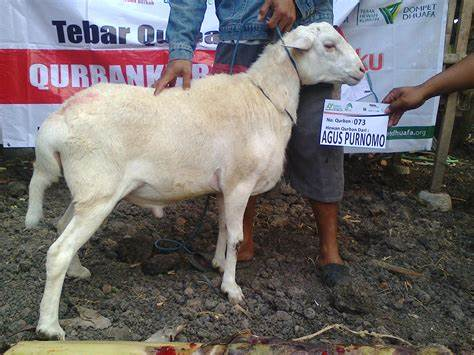

 Prediksi: pecora


In [39]:
from PIL import Image
from IPython.display import display, Image as IPyImage
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess_image(image_path, target_size=(IMG_SIZE, IMG_SIZE)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img, dtype=np.float32)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

image_path = "/kaggle/input/kurban/agus.jpg"
model_path = "model.tflite"
label_path = "tflite/label.txt"

input_data = preprocess_image(image_path)

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_index = np.argmax(output_data)

with open(label_path, "r") as f:
    labels = [line.strip() for line in f.readlines()]

predicted_label = labels[predicted_index]
confidence_score = output_data[0][predicted_index]

display(IPyImage(image_path, width=400))
print(f" Prediksi: {predicted_label}")